In [191]:
import itertools
import os
import sys
import time

import cv2
import hdbscan
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import warnings

from collections import defaultdict
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from PIL import Image
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy import signal
from scipy import stats
from skimage import io, filters, segmentation
from skimage.segmentation import felzenszwalb, mark_boundaries, quickshift, slic, watershed
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KernelDensity, NearestNeighbors, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


%matplotlib notebook
warnings.simplefilter("ignore")

<IPython.core.display.Javascript object>


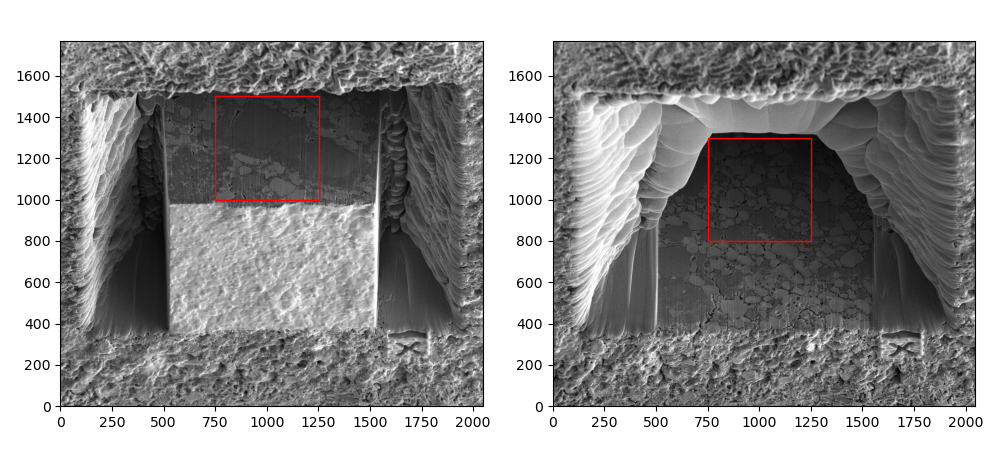

In [5]:
im = plt.imread("../SEM Image/SEM Image - SliceImage - 001.tif")
im2 = plt.imread("../SEM Image/SEM Image - SliceImage - 202.tif")
xstart = 750
ystart = 1000
NX = 501
NY = 501
NZ = 202
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(im, cmap='gray');
ax[0].invert_yaxis();
ax[1].imshow(im2, cmap='gray');
ax[1].invert_yaxis();
rect0 = patches.Rectangle((xstart, ystart), NX, NY, edgecolor='r', fill=False)
ax[0].add_patch(rect0);
rect1 = patches.Rectangle((xstart, ystart - 201), NX, NY, edgecolor='r', fill=False)
ax[1].add_patch(rect1)
plt.tight_layout();
plt.show()

In [6]:
for i in range(NZ):
    file_no = i + 1
    im = plt.imread('../SEM Image/SEM Image - SliceImage - {}.tif'.format(str(file_no).zfill(3)))
    new_im = im[ystart - i:ystart+NY-i, xstart:xstart+NX]
    new_img = Image.fromarray(new_im)
    new_img.save("../unsegmented/%s.tif" % str(i).zfill(3), "TIFF")

## Trainable Weka Segmentation

<IPython.core.display.Javascript object>


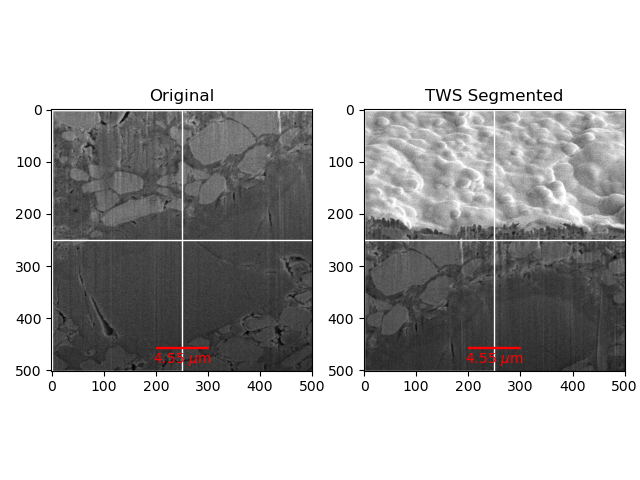

In [7]:
img = plt.imread("../unsegmented/000.tif")
img_tws = plt.imread("../segmented/000.tif")
img_tws2 = np.asarray(Image.open("../segmented/000.tif")).reshape(501, 501)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
rect0 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect1 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect2 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
rect3 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
scalebar0 = AnchoredSizeBar(ax[0].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )
scalebar1 = AnchoredSizeBar(ax[1].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )

ax[0].add_artist(scalebar0)
ax[0].add_patch(rect0)
ax[0].add_patch(rect2)
ax[0].set_title("Original")

ax[1].imshow(img_tws, cmap='gray')
ax[1].add_patch(rect1)
ax[1].add_patch(rect3)
ax[1].add_artist(scalebar1)
ax[1].set_title("TWS Segmented")

plt.savefig("../figures/tws-segmented.png", dpi=500, pad_inches=0);
plt.tight_layout();

### Utility Functions

In [8]:
def load_clusters(X_2d, y_predict):
    img_seg = -2 * np.ones(img.shape)
    for v in np.unique(y_predict):
        X_v = np.argwhere(y_predict == v)
        coords = list(itertools.chain.from_iterable(X_v))
        for coord in coords:
            xx, yy = X_2d[int(coord), :2]
            img_seg[int(xx), int(yy)] = v
    return img_seg

In [9]:
def enhance_clusters(img_seg):
    new_img = -2 * np.ones(img_seg.shape)
    for i in range(img_seg.shape[0]):
        for j in range(img_seg.shape[1]):
            v = img_seg[i, j]
            if v != -2:
                new_img[i, j] = v
                continue
            neighs = [
                (i, j + 1),
                (i + 1, j),
                (i, j - 1),
                (i - 1, j),
                (i + 1, j + 1),
                (i - 1, j - 1),
                (i - 1, j + 1),
                (i + 1, j - 1),
                ]
            vals = []
            for neigh in neighs:
                try:
                    vals.append(img_seg[neigh])
                except IndexError:
                    continue
            set_vals = set(vals)
            if -2 in set_vals:
                set_vals.remove(-2)
            if len(set_vals) == 1:
                new_img[i, j] = set_vals.pop()
    
    return new_img

In [10]:
def neighborhood_average(arr, d=(1, 1), n_min=(0, 0), n_max=(501, 501)):
    out = np.zeros(arr.shape)
    dx, dy = d
    for i in range(n_max[0]):
        for j in range(n_max[1]):
            val = arr[i, j]
            neighbors = arr[max(i - dx, 0):min(i + dx, n_max[0] - 1), max(j - dy, 0):min(j + dy, n_max[1] - 1)]
            out[i, j] = np.mean(neighbors)
    return out


def neighborhood_mode(arr, d=(1, 1), n_min=(0, 0), n_max=(501, 501)):
    out = np.zeros(arr.shape)
    dx, dy = d
    for i in range(n_max[0]):
        for j in range(n_max[1]):
            val = arr[i, j]
            neighbors = arr[max(i - dx, 0):min(i + dx, n_max[0] - 1), max(j - dy, 0):min(j + dy, n_max[1] - 1)]
            out[i, j] = np.mode(neighbors)[0][0]
    return out

In [11]:
def center_of_mass(arr):
    xcom = np.average(arr[:, 0])
    ycom = np.average(arr[:, 1])
    return xcom, ycom

### Edges

#### Input Image as 2D Data

In [171]:
img_no = '150'
min_cluster_size = 2000
threshold = 0.035
img_1 = cv2.imread(f"../unsegmented/{img_no}.tif", cv2.IMREAD_UNCHANGED)
img_11 = neighborhood_average(img_1)
for i in range(25):
    img_11 = neighborhood_average(img_11)
img_2 = filters.meijering(img_11)

#### Edges from Meijering Filter

<IPython.core.display.Javascript object>


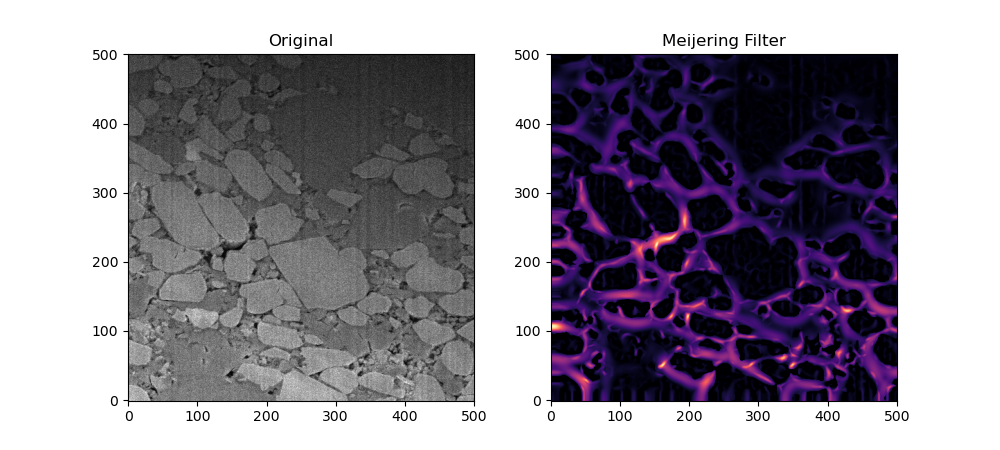

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray')
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(img_2, cmap='magma');
ax[1].invert_yaxis();
ax[1].set_title('Meijering Filter');

#### Enhancement via Local Averaging

In [173]:
img_3 = neighborhood_average(img_2)
for i in range(5):
    img_3 = neighborhood_average(img_3)
img = img_3 / np.max(img_3)

In [174]:
coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
y = np.array([img_1[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1) / 255
y_ = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_2d = np.hstack((coords, y, y_))

### HDBSCAN Clustering

#### Optimal Threshold

<IPython.core.display.Javascript object>


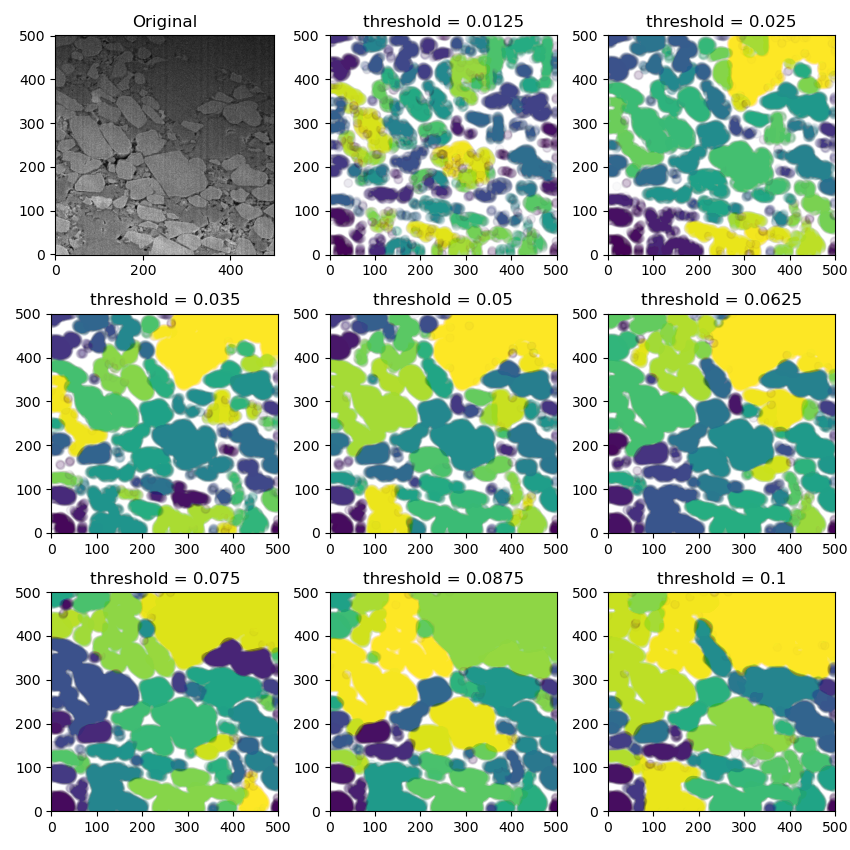

In [190]:
thresholds = [0.0125, 0.025, 0.035, 0.05, 0.0625, 0.075, 0.0875, 0.1]
fig, ax = plt.subplots(3, 3, figsize=(8.5, 8.5))
ax[0, 0].imshow(img_1, cmap='gray')
ax[0, 0].invert_yaxis();
ax[0, 0].set_title('Original');
for idx, threshold in enumerate(thresholds):
    coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
    y = np.array([img_1[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1) / 255
    y_ = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
    X_2d = np.hstack((coords, y, y_))

    # hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=5, gen_min_span_tree=True)
    y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

    # results
    ix = int((idx + 1) / 3)
    iy = (idx + 1) % 3
    ax[ix, iy].scatter(X_2d[:, 1], X_2d[:, 0], c=y_predict, alpha=0.01)
    ax[ix, iy].set_title(f"threshold = {threshold}");
    ax[ix, iy].set_xlim([0, 500]);
    ax[ix, iy].set_ylim([0, 500]);
plt.tight_layout();

### Segmentation
* Use optimal threshold to select feature points for clusters
* Identify clusters using hdbscan
* Backfill missing values in clusters to ensure dense cluster without small holes
* Use clusters to label training data
* Update training data with void clusters information
* Deploy model using the training data in order to predict the whole image

#### 1. Void Phase

<IPython.core.display.Javascript object>


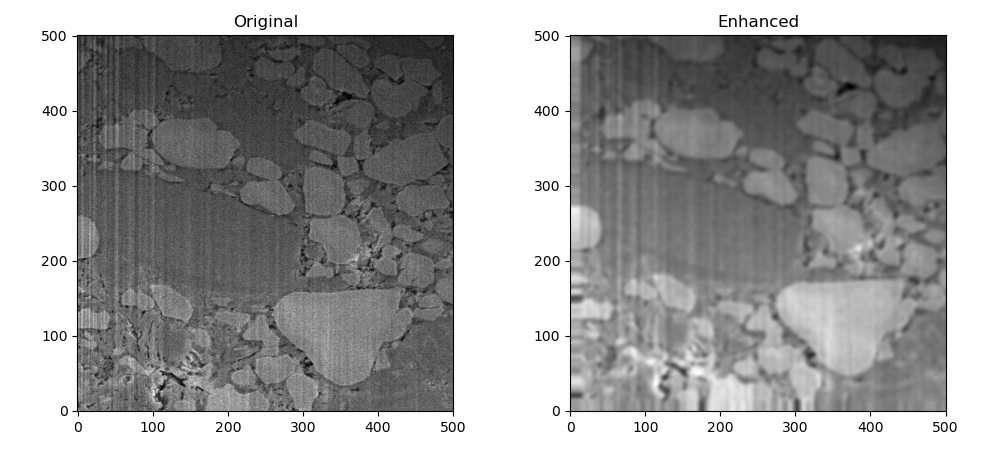

In [112]:
img_1 = cv2.imread(f"../unsegmented/{img_no}.tif", cv2.IMREAD_UNCHANGED)
img_2 = neighborhood_average(img_1 / 255)
for i in range(25):
    img_2 = neighborhood_average(img_2)

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray');
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(img_2, cmap='gray');
ax[1].invert_yaxis();
ax[1].set_title(f"Enhanced");
plt.tight_layout();

In [98]:
cv2.imwrite('../trial.tif', (img_2 * 255).astype(np.uint8))

True

<IPython.core.display.Javascript object>


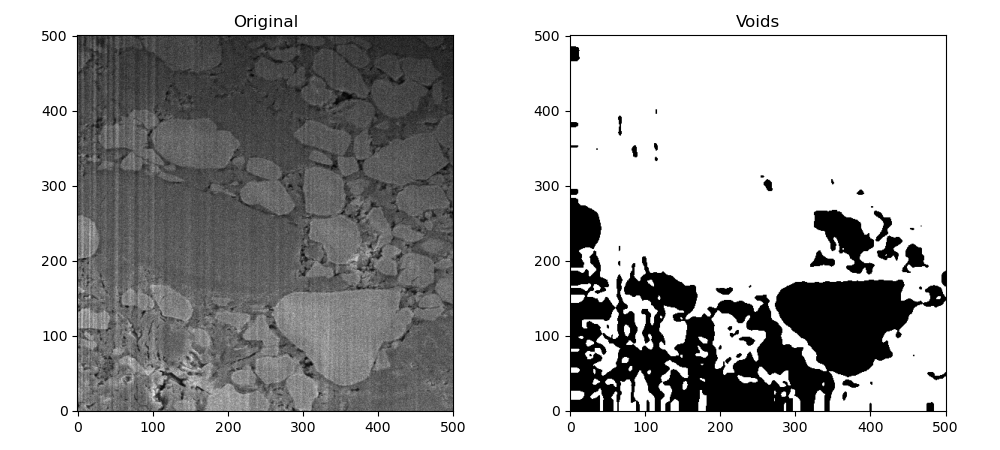

In [100]:
voids = img_2 < 0.25

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray');
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(voids, cmap='gray');
ax[1].invert_yaxis();
ax[1].set_title(f"Voids");
plt.tight_layout();

#### Non-void Single-Phase Clusters

In [184]:
coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
y = np.array([img_1[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1) / 255
y_ = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X_2d = np.hstack((coords, y, y_))

clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

<IPython.core.display.Javascript object>


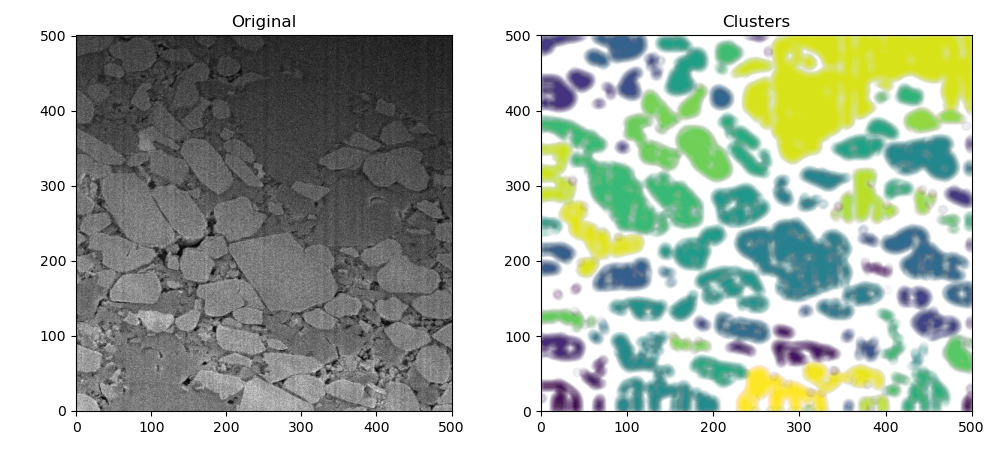

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray')
ax[0].invert_yaxis();
ax[1].scatter(X_2d[:, 1], X_2d[:, 0], c=y_predict, alpha=0.01)
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

<IPython.core.display.Javascript object>


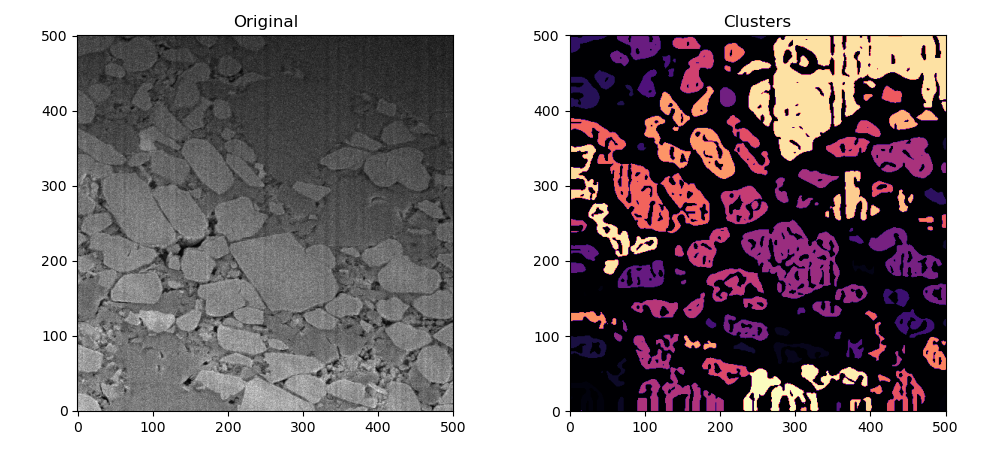

In [186]:
img_seg = -2 * np.ones(img.shape)

averages = []
for v in np.unique(y_predict):
    X_v = np.argwhere(y_predict == v)
    coords = list(itertools.chain.from_iterable(X_v))
    for coord in coords:
        xx, yy = X_2d[int(coord), :2]
        img_seg[int(xx), int(yy)] = v
    px_avg = np.mean(y[X_v])
    averages.append(px_avg)

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray')
ax[0].invert_yaxis();
ax[1].imshow(img_seg, cmap='magma')
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

<IPython.core.display.Javascript object>


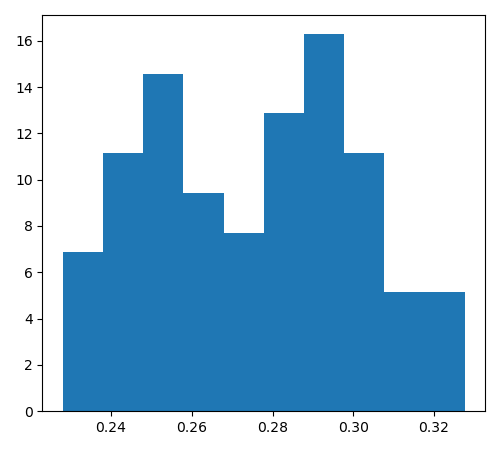

In [187]:
fig, ax = plt.subplots(figsize=(5, 4.5))
bins = ax.hist(averages, bins=10, density=True);
plt.tight_layout();

<IPython.core.display.Javascript object>


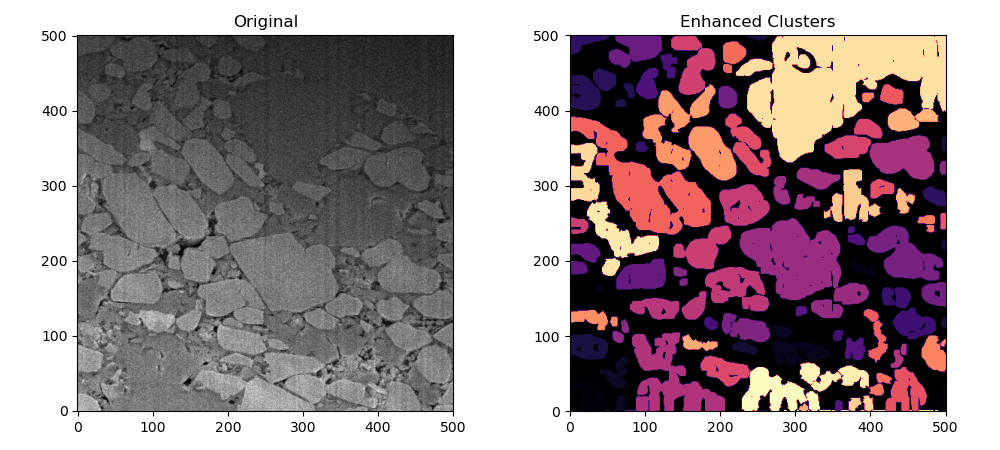

In [188]:
new_img = enhance_clusters(img_seg)
for i in range(1):
    new_img = enhance_clusters(new_img)

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img_1, cmap='gray')
ax[0].invert_yaxis();
ax[0].set_title('Original');
ax[1].imshow(new_img, cmap='magma')
ax[1].set_title(f"Enhanced Clusters");
ax[1].set_xlim([0, 500]);
ax[1].set_ylim([0, 500]);
plt.tight_layout();

<IPython.core.display.Javascript object>


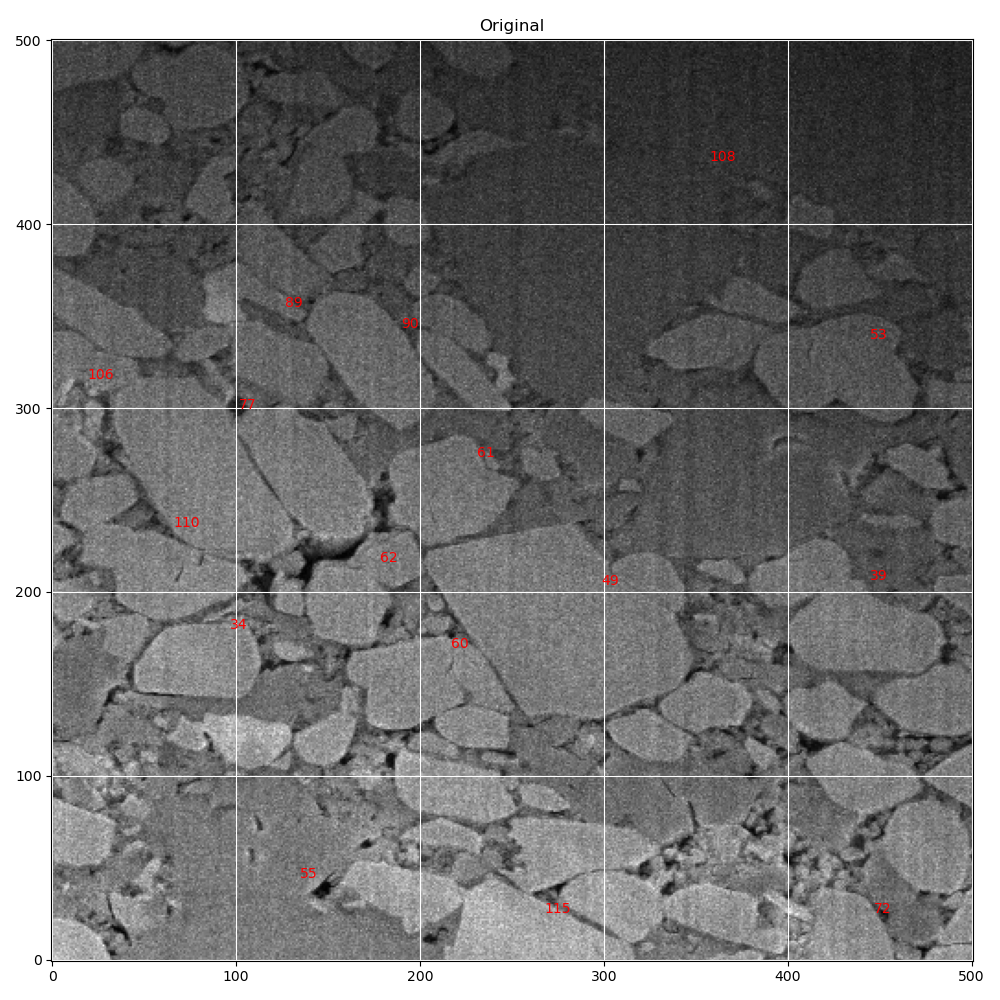

In [189]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_1, cmap='gray')
ax.invert_yaxis();
ax.grid(which='both', c='white')
ax.set_title('Original');

for v in np.unique(new_img):
    if v in (-1, -2):
        continue
    coords = np.argwhere(new_img == v)
    values = np.array([img_1[tuple(c)] for c in coords]).reshape(-1, 1) / 255
    len_cluster = coords.shape[0]
    if len_cluster < min_cluster_size:
        continue

    xcom, ycom = center_of_mass(coords)
    ax.text(ycom, xcom, int(v), c='red')
    plt.tight_layout();

#### Label Training Images

<IPython.core.display.Javascript object>


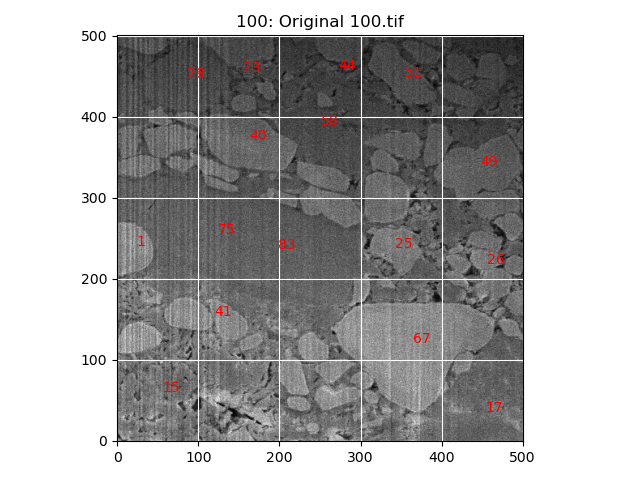

<IPython.core.display.Javascript object>


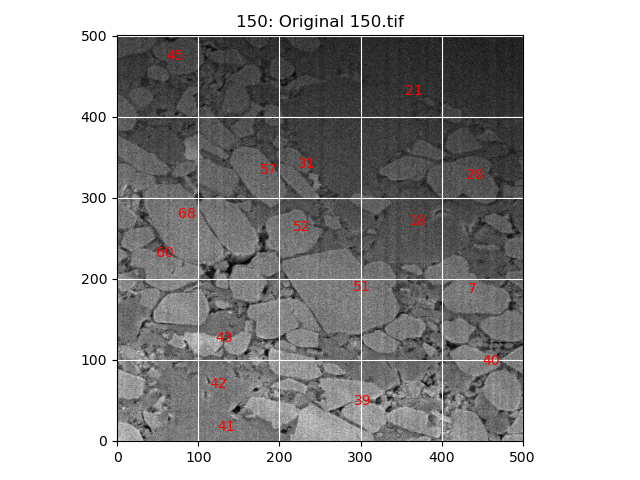

<IPython.core.display.Javascript object>


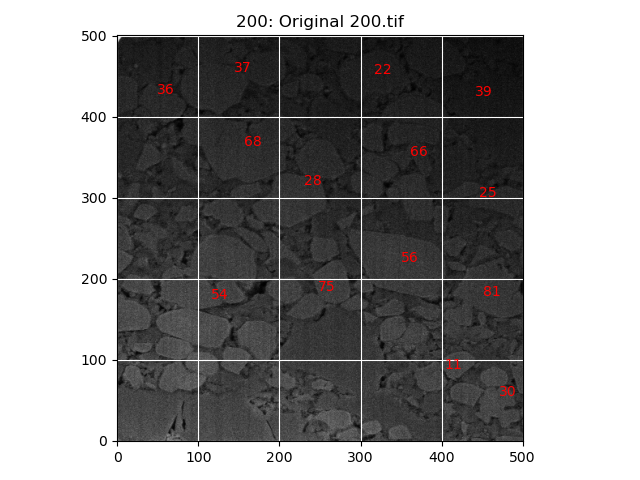

In [156]:
training_images = [
#                    '000.tif',
#                    '025.tif',
#                    '050.tif',
#                    '075.tif',
                   '100.tif',
#                    '125.tif',
                   '150.tif',
#                    '175.tif',
                   '200.tif',
                  ]
NX = 501
NY = 501
NZ = 202
training = defaultdict(lambda: [])

for train_image in training_images:
    z = int(train_image.split('.')[0])

    # input data
    img_1 = cv2.imread("../unsegmented/" + train_image, cv2.IMREAD_UNCHANGED)
    img_11 = neighborhood_average(img_1)
    for i in range(25):
        img_11 = neighborhood_average(img_11)
    img_2 = filters.meijering(img_11)
    img_3 = neighborhood_average(img_2)
    for i in range(5):
        img_3 = neighborhood_average(img_3)
    img = img_3 / np.max(img_3)
    
    # original
    fig, ax = plt.subplots()
    ax.imshow(img_1, cmap='gray')
    ax.invert_yaxis();
    ax.set_title(f'{z}: Original {train_image}');
    ax.grid(which='both', c='white');

    # features
    coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
    y = np.array([img_1[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
    y_ = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
    X_2d = np.hstack((coords, y, y_))

    # hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True, cluster_selection_method='eom')
    y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

    # enhance clusters
    img_seg = load_clusters(X_2d, y_predict)
    new_img = enhance_clusters(img_seg)
    for i in range(1):
        new_img = enhance_clusters(new_img)
    
    # big enough clusters
    clusters = []
    for v in np.unique(new_img):
        if v in (-1, -2):
            continue

        coords = np.argwhere(new_img == v)
        values = np.array([img_1[tuple(c)] for c in coords]).reshape(-1, 1) / 255
        len_cluster = coords.shape[0]
        if len_cluster < min_cluster_size:
            continue

        ycom, xcom = center_of_mass(coords)
        ax.text(xcom, ycom, int(v), c='red');
        phase = -2
        for (xx, yy) in coords:
            df_row = {"dummy_cluster_id": int(v), "x": xx, 'y': yy, 'z': z, 'px_value': img_1[xx, yy], 'phase': phase}
            training[z].append(df_row)
    plt.tight_layout();
    plt.show();

Now, from the plots label the training data into correct phases.

In [157]:
df_train = pd.DataFrame(
    {"x": [], 'y': [], 'z': [], 'px_value': [], 'phase': []}
)

In [158]:
phases = {
    100: {
        1: [15, 17, 28, 58, 75, 83,],
    },
    150: {
        1: [18, 21, 41, 42],
    },
    200: {
        1: [39,],
    },
}
for k in phases.keys():
    phase1 = phases[k][1]
    zdata = training[k]
    for row in zdata:
        df_row = row.copy()
        dummy_cluster_id = df_row['dummy_cluster_id']
        del df_row['dummy_cluster_id']
        if dummy_cluster_id in phase1:
            df_row['phase'] = 1
        else:
            df_row['phase'] = 2
        df_train = df_train.append(df_row, ignore_index=True)

#### Testing Data

In [159]:
df_test = pd.DataFrame(
    {"x": [], 'y': [], 'z': [], 'px_value': [], 'phase': []}
)
for idx in range(100, 153):
    print(idx)
    z = idx

    # input data
    fname = str(z).zfill(3) + ".tif"
    img_1 = cv2.imread("../unsegmented/" + fname, cv2.IMREAD_UNCHANGED)
    img_11 = neighborhood_average(img_1)
    for i in range(25):
        img_11 = neighborhood_average(img_11)
    img_2 = filters.meijering(img_11)
    img_3 = neighborhood_average(img_2)
    for i in range(5):
        img_3 = neighborhood_average(img_3)
    img = img_3 / np.max(img_3)

    # features
    coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
    y = np.array([img_1[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
    X_2d = np.hstack((coords, y))

    # hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True, cluster_selection_method='eom')
    y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

    # enhance clusters
    img_seg = load_clusters(X_2d, y_predict)
    new_img = enhance_clusters(img_seg)
    for i in range(1):
        new_img = enhance_clusters(new_img)

    # big enough clusters
    clusters = []
    for v in np.unique(new_img):
        if v in (-1, -2):
            continue

        coords = np.argwhere(new_img == v)
        values = np.array([img_1[tuple(c)] for c in coords]).reshape(-1, 1)
        len_cluster = coords.shape[0]
        if len_cluster < min_cluster_size:
            continue

        phase = -2
        for (xx, yy) in coords:
            df_row = {"x": xx, 'y': yy, 'z': z, 'px_value': img_1[xx, yy], 'phase': phase}
            df_test = df_test.append(df_row, ignore_index=True)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


In [160]:
X_train = df_train[[c for c in df_train.columns if c not in ['phase']]].values
y_train = df_train['phase'].values.reshape(-1, 1)

X_test = df_test[[c for c in df_test.columns if c  not in ['phase']]].values
y_test = df_test['phase'].values.reshape(-1, 1)

#### Classifying Unsegmented Single-Phase Clusters
##### Decision Tree Classifier

In [32]:
# dtc = DecisionTreeClassifier()
# dtc.fit(X_train, y_train)
# y_predict = dtc.predict(X_test)
# print(dtc.score(X_train, y_train))

##### Random Forest Classifier

In [161]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(clf.score(X_train, y_train))

1.0


##### MLP Classifier

In [143]:
# clf = MLPClassifier(max_iter=300)
# clf.fit(X_train, y_train)
# y_predict = clf.predict(X_test)
# print(clf.score(X_train, y_train))

0.5964912280701754


##### SVC

In [35]:
# svc = SVC(kernel='rbf',gamma=1e-3, C=1000)
# svc.fit(X_train, y_train)
# y_predict = svc.predict(X_test)

##### kNN

In [139]:
# knn = KNeighborsClassifier(n_neighbors=4)
# knn.fit(X_train, y_train)
# y_predict = knn.predict(X_test)

##### naive Bayes

In [37]:
# NB = ComplementNB()
# NB.fit(X_train, y_train)
# y_predict = NB.predict(X_test)

In [38]:
# clf = HistGradientBoostingClassifier()
# clf.fit(X_train, y_train)
# y_predict = clf.predict(X_test)

In [39]:
# clf = AdaBoostClassifier()
# clf.fit(X_train, y_train)
# y_predict = clf.predict(X_test)

In [40]:
# clf = ExtraTreesClassifier()
# clf.fit(X_train, y_train)
# y_predict = clf.predict(X_test)

In [162]:
df_test['phase'] = y_predict

In [169]:
test_img_no = 150
slice5 = df_test[df_test['z'] == test_img_no]
x5 = slice5['x']
y5 = slice5['y']
slice5

x      y      z  px_value  phase
5903833  292.0  451.0  150.0      27.0    2.0
5903834  292.0  452.0  150.0      28.0    2.0
5903835  292.0  453.0  150.0      31.0    2.0
5903836  292.0  454.0  150.0      32.0    2.0
5903837  292.0  455.0  150.0      27.0    2.0
...        ...    ...    ...       ...    ...
6009859  375.0    4.0  150.0      33.0    1.0
6009860  375.0    5.0  150.0      43.0    1.0
6009861  375.0    6.0  150.0      25.0    2.0
6009862  375.0    7.0  150.0      29.0    2.0
6009863  375.0    8.0  150.0      32.0    1.0

[106031 rows x 5 columns]

<IPython.core.display.Javascript object>


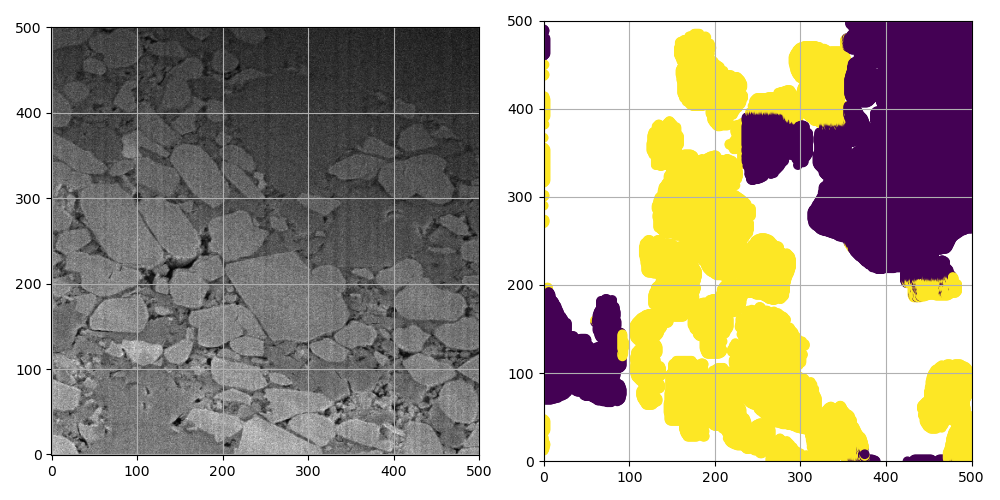

In [170]:
img_01 = cv2.imread('../unsegmented/{}.tif'.format(str(int(test_img_no)).zfill(3)), cv2.IMREAD_UNCHANGED)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_01, cmap='gray');
ax[0].invert_yaxis();
ax[0].grid();
ax[1].scatter(x5, y5, c=slice5['phase']);
ax[1].grid();
ax[1].set_xlim([0, 500])
ax[1].set_ylim([0, 500])
plt.tight_layout();
plt.show();

#### 3D Clustering

In [46]:
# n_files = min(6, NZ)
# data3d = -100 * np.ones((NX, NY, n_files))

# for idx in range(6):
#     z = idx
#     # input data
#     fname = str(z).zfill(3) + ".tif"
#     print(fname)
#     img_1 = np.array(cv2.imread("../unsegmented/" + fname, cv2.IMREAD_UNCHANGED))
#     img_2 = np.array(filters.meijering(img_1))
#     img_3 = neighborhood_average(img_2)
#     img_3 = neighborhood_average(img_3)
#     img_3 = neighborhood_average(img_3)
#     img_3 = neighborhood_average(img_3)
#     img = img_3 / np.max(img_3)

#     # features
#     threshold = 0.075 - 0.01 * (z + 1) / NZ
#     coords = np.argwhere(np.logical_and(np.greater_equal(img, 0), np.less_equal(img, threshold)))
#     y = np.array([img_1[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1) / 255
#     X_2d = np.hstack((coords, y))

#     # hdbscan
#     clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
#     y_predict = clusterer.fit_predict(X_2d).reshape(-1, 1)

#     # enhance clusters
#     img_seg = load_clusters(X_2d, y_predict)
#     new_img = enhance_clusters(img_seg)
#     for i in range(2):
#         new_img = enhance_clusters(new_img)

#     # big enough clusters
#     clusters = []
#     for v in np.unique(new_img):
#         if v in (-1, -2):
#             continue
#         #
#         coords = np.argwhere(new_img == v)
        
#         values = np.array([img_1[tuple(c)] for c in coords]).reshape(-1, 1)
#         len_cluster = coords.shape[0]
#         if len_cluster < 1500:
#             continue
#         for c in coords:
#             data3d[c[0], c[1], z] = img_1[c[0], c[1]]

In [47]:
# coords3 = np.argwhere(data3d != -100)
# print(coords3.shape)
# y3 = np.array([data3d[tuple(c)] for c in coords3]).reshape(-1, 1)
# X_3d = np.hstack((coords3, y3))

In [48]:
# data3d = None

In [49]:
# clusterer = hdbscan.HDBSCAN(min_cluster_size=25, cluster_selection_epsilon=2, gen_min_span_tree=True)
# y3_predict = clusterer.fit_predict(X_3d).reshape(-1, 1)

In [50]:
# y3_predict.shape

In [51]:
# print(np.unique(y3_predict))

In [52]:
# import pickle
# X_3d.shape, y_predict.shape

In [53]:
# locs = np.where(y3_predict.reshape(-1) == 0)
# len0 = len(locs[0])
# data0 = X_3d[locs, :3].reshape(len0, 3)
# print(data0.shape)

In [54]:
# locs1 = np.where(y3_predict.reshape(-1) == 1)
# len1 = len(locs1[0])
# data1 = X_3d[locs1, :3].reshape(len1, 3)

In [55]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter3D(data1[:, 0], data1[:, 1], data1[:, 2], alpha=0.5);
# ax.set_axis_off();
# plt.tight_layout();

In [56]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter3D(data0[:, 0], data0[:, 1], data0[:, 2], alpha=0.5);
# ax.set_axis_off();
# plt.tight_layout();